In [1]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

In [14]:
SOURCE_VIDEO_PATH = "people.mp4"
TARGET_VIDEO_PATH = "people-result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

In [15]:
SOURCE = np.array([
    [1252, 787],
    [2298, 803],
    [5039, 2159],
    [-550, 2159]
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 250

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

In [16]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

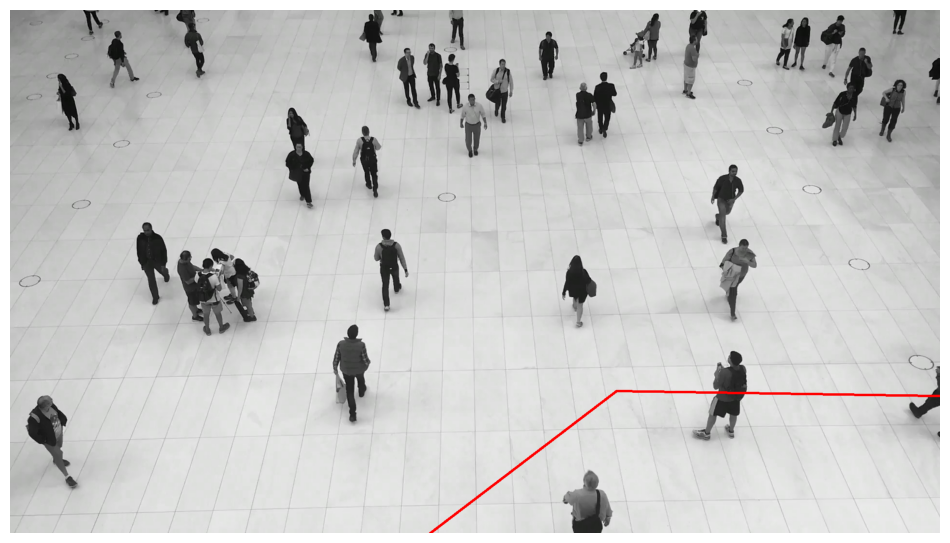

In [17]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.RED, thickness=4)
sv.plot_image(annotated_frame)

In [18]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [19]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

In [20]:
model = YOLO(MODEL_NAME)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD
)

# annotators configuration
thickness = sv.calculate_optimal_line_thickness(
    resolution_wh=video_info.resolution_wh
)
text_scale = sv.calculate_optimal_text_scale(
    resolution_wh=video_info.resolution_wh
)
bounding_box_annotator = sv.BoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    triggering_anchors=[sv.Position.BOTTOM_CENTER]
)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # loop over source video frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(
            anchor=sv.Position.BOTTOM_CENTER
        )

        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # format labels
        labels = []

        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:
                # calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                labels.append(f"#{tracker_id} {int(speed)} km/h")

        # annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # add frame to target video
        sink.write_frame(annotated_frame)

  0%|          | 0/341 [00:00<?, ?it/s]

100%|██████████| 341/341 [00:31<00:00, 10.96it/s]


In [1]:
import cv2
import time

# Đọc ảnh đầu vào
image = cv2.imread("example.png")

# CPU resize
start_cpu = time.time()
resized_cpu = cv2.resize(image, (640, 480))
end_cpu = time.time()
print(f"Resize on CPU: {end_cpu - start_cpu:.4f} seconds")

# GPU resize
gpu_mat = cv2.cuda_GpuMat()
gpu_mat.upload(image)  # Upload ảnh lên GPU

start_gpu = time.time()
resized_gpu = cv2.cuda.resize(gpu_mat, (640, 480))
end_gpu = time.time()
print(f"Resize on GPU: {end_gpu - start_gpu:.4f} seconds")

# Tải ảnh từ GPU xuống CPU để hiển thị
resized_gpu_result = resized_gpu.download()

cv2.imshow("Resized on CPU", resized_cpu)
cv2.imshow("Resized on GPU", resized_gpu_result)
cv2.waitKey(0)
cv2.destroyAllWindows()


Resize on CPU: 0.0000 seconds


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\core\include\opencv2/core/private.cuda.hpp:106: error: (-216:No CUDA support) The library is compiled without CUDA support in function 'throw_no_cuda'


In [2]:
import cv2
import numpy as np

# Check if GPU support is available
if not cv2.cuda.getCudaEnabledDeviceCount():
    print("CUDA-enabled GPU not found. Exiting...")

CUDA-enabled GPU not found. Exiting...
